In [1]:
# import the necessary libraries
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset

# import dataloader class
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# import visualisation tool
import matplotlib.pyplot as plt
import seaborn as sns

# import time to time the training
import time


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")

GPU is available


In [3]:
# load in our dataset
# define the dataset path
dataset_path = 'archive'
train_path = dataset_path + '/Training'
test_path = dataset_path + '/Testing'

In [4]:
# We will use EfficientNet 0b as our base pretrained model
from torchvision.models import efficientnet_b0

# Load the pretrained model
model_pretrained = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

model_pretrained

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [5]:
# the model expects a 3 channel input image with size 224x224
# we will use the same transforms as the original model

# define the transforms
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# we transform our data using the transforms
# we will use the ImageFolder class to load the data

training_data = datasets.ImageFolder(train_path, transform=data_transforms)
testing_data = datasets.ImageFolder(test_path, transform=data_transforms)

# we want the data to be grouped into non-tumour and tumour. The non-tumour class is class 2, while the tumour classes are 0, 1 , 3

# we will create a custom dataset class to group the data into tumour and non-tumour classes
class_mapping = {0: 1, 1: 1, 2: 0, 3: 1}

class DatasetBinary(Dataset):
    def __init__(self, dataset, class_mapping):
        self.dataset = dataset
        self.class_mapping = class_mapping
        self.targets = [class_mapping[target] for _, target in self.dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, self.class_mapping[target]

# create the binary datasets
training_data_binary = DatasetBinary(training_data, class_mapping)
testing_data_binary = DatasetBinary(testing_data, class_mapping)

# create the dataloaders
train_loader = DataLoader(training_data_binary, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data_binary, batch_size=32, shuffle=False)


In [6]:
# we should freeze the weights of the pretrained model
for param in model_pretrained.parameters():
    param.requires_grad = False

# unfreeze the last few layers
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

# we will add a new fully connected layer to the model
model_pretrained.fc = nn.Linear(1280, 2)

# define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)

In [7]:
# print the model where gradient is required
for name, param in model_pretrained.named_parameters():
    if param.requires_grad:
        print(name)

classifier.1.weight
classifier.1.bias
fc.weight
fc.bias


In [8]:
if torch.cuda.is_available():
    print("Training on GPU, moving data to GPU...")
    device = torch.device('cuda')
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
    test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

Training on GPU, moving data to GPU...


In [9]:
# train the model
if torch.cuda.is_available():
    model_pretrained.to(device)
    
epochs = 20
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(epochs):
    model_pretrained.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model_pretrained(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')

/home/adam/.conda/envs/torch/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Loss: 0.4780009388923645 performed in 4.175011396408081 seconds
Epoch 2, Loss: 0.23415812849998474 performed in 3.787771224975586 seconds
Epoch 3, Loss: 0.19279231131076813 performed in 3.8034095764160156 seconds
Epoch 4, Loss: 0.12573792040348053 performed in 3.81003999710083 seconds
Epoch 5, Loss: 0.19284768402576447 performed in 3.937854290008545 seconds
Epoch 6, Loss: 0.09996695816516876 performed in 4.196531057357788 seconds
Epoch 7, Loss: 0.07221946120262146 performed in 4.363491058349609 seconds
Epoch 8, Loss: 0.1098327711224556 performed in 4.605038166046143 seconds
Epoch 9, Loss: 0.07989241182804108 performed in 4.569948434829712 seconds
Epoch 10, Loss: 0.06118408218026161 performed in 4.5723607540130615 seconds
Epoch 11, Loss: 0.1126805990934372 performed in 4.56996488571167 seconds
Epoch 12, Loss: 0.05403889715671539 performed in 4.571275472640991 seconds
Epoch 13, Loss: 0.11152999103069305 performed in 4.570643186569214 seconds
Epoch 14, Loss: 0.042052701115608215 

In [10]:
# evaluate the model with loss and accuracy
model_pretrained.eval()
correct = 0
total = 0
loss = 0

test_temp = test_loader_gpu if torch.cuda.is_available() else test_loader
with torch.no_grad():
    for data, target in test_temp:
        output = model_pretrained(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Loss: {loss / len(test_loader)}')
print(f'Accuracy: {correct / total}')

Loss: 0.4149616909428285
Accuracy: 0.8426395939086294


<Axes: >

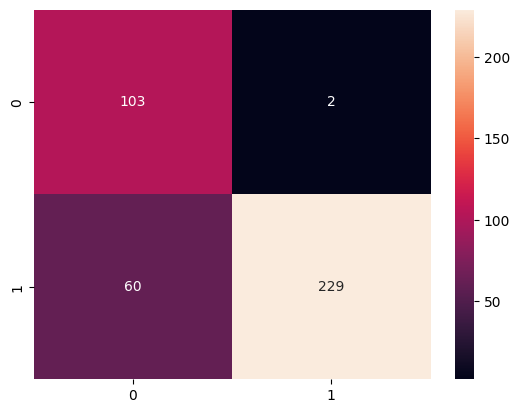

In [11]:
# we should plot the confusion matrix
import seaborn as sns
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
sns.heatmap(confusion_matrix, annot=True, fmt='g')

Let's try unfreezing more of the pretrained model

In [12]:
# first let's unload the model from the GPU
model_pretrained.to('cpu')

# refresh the model by loading it again
model_pretrained = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# freeze the weights of the model
for param in model_pretrained.parameters():
    param.requires_grad = False

# add a new fully connected layer
model_pretrained.fc = nn.Linear(1280, 2)

# unfreeze the last few layers
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[8].named_parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[7].named_parameters():
    param.requires_grad = True

# define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)


In [13]:
# train the model
if torch.cuda.is_available():
    model_pretrained.to(device)

epochs = 10
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(epochs):
    model_pretrained.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model_pretrained(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')

Epoch 1, Loss: 0.05273836851119995 performed in 4.337029218673706 seconds
Epoch 2, Loss: 0.004105393774807453 performed in 4.436016321182251 seconds
Epoch 3, Loss: 0.006017778534442186 performed in 4.853262901306152 seconds
Epoch 4, Loss: 0.0004915688186883926 performed in 5.151642799377441 seconds
Epoch 5, Loss: 0.027702076360583305 performed in 5.1280810832977295 seconds
Epoch 6, Loss: 0.0002630377421155572 performed in 5.129089832305908 seconds
Epoch 7, Loss: 0.0001577220537001267 performed in 5.126498222351074 seconds
Epoch 8, Loss: 9.834951924858615e-05 performed in 5.129996061325073 seconds
Epoch 9, Loss: 0.00017660728190094233 performed in 5.133860349655151 seconds
Epoch 10, Loss: 0.00010292023216607049 performed in 5.128572225570679 seconds
Training performed in 49.554996490478516 seconds


In [14]:
# evaluate the model on accuracy and loss
model_pretrained.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Loss: {loss / len(test_loader)}')
print(f'Accuracy: {correct / total}')

Loss: 0.5915007949718599
Accuracy: 0.8959390862944162


Text(50.72222222222221, 0.5, 'Actual')

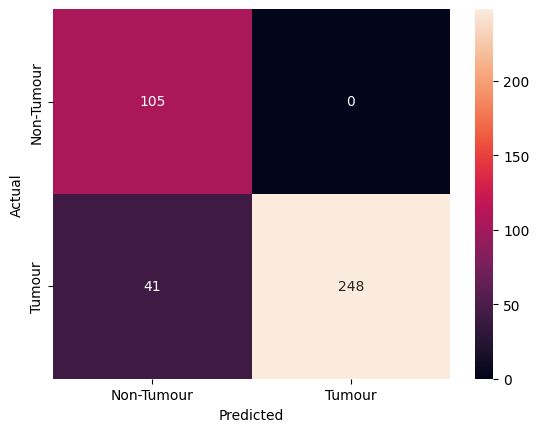

In [15]:
# we should plot the confusion matrix
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
classes = ['Non-Tumour', 'Tumour']
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
# set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

This pretrained model is so good that we might venture to use it for the non-binary classification as well!

In [16]:
train_loader_quad = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader_quad = DataLoader(testing_data, batch_size=32, shuffle=False)

In [17]:
# place the old model in the cpu
model_pretrained.to('cpu')

# refresh the model
model_pretrained = efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# freeze the weights of the model
for param in model_pretrained.parameters():
    param.requires_grad = False

# add a new fully connected layer
model_pretrained.fc = nn.Linear(1280, 4)

# unfreeze the last few layers
for param in model_pretrained.classifier.parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[8].named_parameters():
    param.requires_grad = True

for name, param in model_pretrained.features[7].named_parameters():
    param.requires_grad = True

# define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)

In [18]:
# put our data on the GPU
if torch.cuda.is_available():
    model_pretrained.to(device)
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader_quad]
    test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader_quad]

In [19]:
# put the model on the GPU if available
if torch.cuda.is_available():
    model_pretrained.to(device)

# train the model
epochs = 10
start = time.time()
train_start = start
train_loc = train_loader_gpu if torch.cuda.is_available() else train_loader_quad
for epoch in range(epochs):
    model_pretrained.train()
    running_loss = 0.0
    for data, target in train_loc:
        optimizer.zero_grad()
        output = model_pretrained(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()} performed in {time.time() - start} seconds')
    start = time.time()
print(f'Training performed in {time.time() - train_start} seconds')


Epoch 1, Loss: 0.30273640155792236 performed in 4.285256624221802 seconds
Epoch 2, Loss: 0.10472286492586136 performed in 4.264821290969849 seconds
Epoch 3, Loss: 0.01748482696712017 performed in 4.484738826751709 seconds
Epoch 4, Loss: 0.004058977589011192 performed in 4.755115509033203 seconds
Epoch 5, Loss: 0.03289002552628517 performed in 5.062491178512573 seconds
Epoch 6, Loss: 0.007267287001013756 performed in 5.146307468414307 seconds
Epoch 7, Loss: 0.001011993968859315 performed in 5.1320579051971436 seconds
Epoch 8, Loss: 0.04285305365920067 performed in 5.133116006851196 seconds
Epoch 9, Loss: 0.002911409130319953 performed in 5.135399103164673 seconds
Epoch 10, Loss: 0.004356470424681902 performed in 5.133138179779053 seconds
Training performed in 48.53312563896179 seconds


In [22]:
# evaluate the model with loss and accuracy
model_pretrained.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Loss: {loss / len(test_loader_quad)}')
print(f'Accuracy: {correct / total}')


Loss: 2.288645053584612
Accuracy: 0.7791878172588832


Text(50.58159722222221, 0.5, 'Actual')

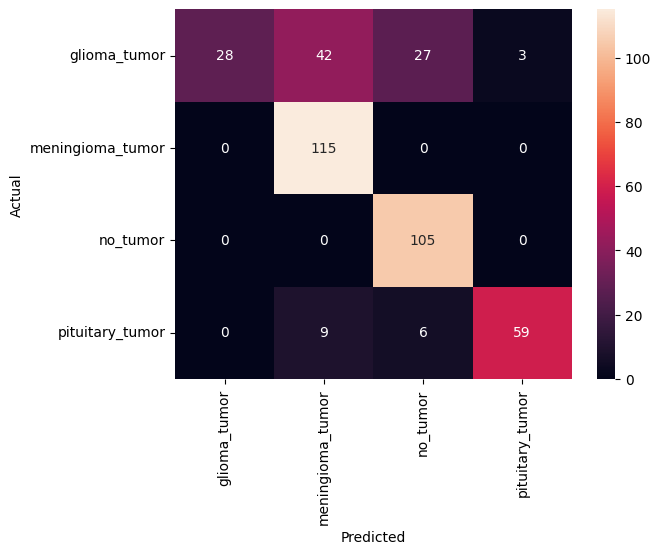

In [21]:
# we should plot the confusion matrix
confusion_matrix = torch.zeros(4, 4)
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_pretrained(data)
        _, predicted = torch.max(output, 1)
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
classes = train_loader_quad.dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
# set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

Where to go from here?
- With 90% accuracy on the binary classification, we can try achieving 85% or higher accuracy on the second step to get a higher accuracy overall than what we have had historically (78%)
- Fiddle with data augmentation and inspect the dataset